In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('future.no_silent_downcasting', True)
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Data Preparation

In [2]:
data_path = '/kaggle/input/the-depression-dataset/data/'
activity = pd.DataFrame()
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if filename == 'scores.csv':
            continue
        tmp = pd.read_csv(os.path.join(dirname, filename))
        tmp['timestamp'] = pd.to_datetime(tmp['timestamp'])
        tmp['number'] = filename[:-4]
        tmp = tmp.drop(columns=['date'])
        activity = pd.concat([activity, tmp])

Activity files contains following columns:

* timestamp(one minute intervals)
* date(date of measurement)
* activity(activity measurement from the actigraph watch)

In [3]:
activity.sample(5)

,timestamp,activity,number
2208,2004-02-18 21:48:00,12,control_23
13728,2003-12-04 21:48:00,733,control_15
17473,2004-01-21 12:13:00,887,control_19
17646,2004-06-08 18:36:00,106,condition_9
12699,2005-11-17 05:09:00,0,condition_17


In [4]:
scores_path = '/kaggle/input/the-depression-dataset/data/scores.csv'
df = pd.read_csv(scores_path)

The scores file contains the following columns:

* number(patient identifier)
* 
* days(number of days of measurements)
* 
* gender(1 or 2 for female or male)
* 
* age(age in age groups)
* 
* afftype(1: bipolar II, 2: unipolar depressive, 3: bipolar I) 
* 
* melanch (1: melancholia, 2: no melancholia)
* 
* inpatient (1: inpatient, 2: outpatient)
* 
* edu (education grouped in years)
* 
* marriage (1: married or cohabiting, 2: single)
* 
* work (1: working or studying, 2: unemployed/sick leave/pension)
* 
* madrs1 (MADRS score when measurement started)
* 
* madrs2 (MADRS when measurement stopped)

In [5]:
df.sample(5)

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2
44,control_22,13,1,25-29,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
9,condition_10,9,2,45-49,2.0,2.0,2.0,6-10,1.0,2.0,28.0,21.0
12,condition_13,14,2,35-39,1.0,2.0,2.0,11-15,2.0,2.0,18.0,13.0
20,condition_21,13,2,35-39,2.0,2.0,1.0,6-10,2.0,2.0,26.0,21.0
8,condition_9,13,2,45-49,1.0,NaN,2.0,6-10,1.0,2.0,26.0,26.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   number     55 non-null     object 
 1   days       55 non-null     int64  
 2   gender     55 non-null     int64  
 3   age        55 non-null     object 
 4   afftype    23 non-null     float64
 5   melanch    20 non-null     float64
 6   inpatient  23 non-null     float64
 7   edu        53 non-null     object 
 8   marriage   23 non-null     float64
 9   work       23 non-null     float64
 10  madrs1     23 non-null     float64
 11  madrs2     23 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 5.3+ KB


In [7]:
print(f'age unique: {df.age.unique()}\nedo unique: {df.edu.unique()}')

age unique: ['35-39' '40-44' '45-49' '25-29' '50-54' '20-24' '60-64' '55-59' '30-34'
 '65-69']
edo unique: ['6-10' '11-15' '16-20' ' ' nan]


In [8]:
df.edu = df.edu.replace({
    '6-10':1,
    '11-15':2,
    '16-20':3,
    ' ':np.nan
})
df.age = df.age.apply(lambda x: int(x[:2]))

In [9]:
df['condition'] = df.number.apply(lambda x: 1 if 'condition' in x else 0)
df = df.join(
    activity.groupby('number')[['activity']].mean(), on='number'
)
df['madrs_delta']= df.madrs2 - df.madrs1

In [10]:
df.describe()

,days,gender,age,afftype,melanch,inpatient,marriage,work,madrs1,madrs2,condition,activity,madrs_delta
count,55.000000,55.000000,55.000000,23.000000,20.000000,23.000000,23.000000,23.000000,23.000000,23.000000,55.000000,55.000000,23.000000
mean,12.600000,1.454545,38.363636,1.739130,1.950000,1.782609,1.521739,1.869565,22.739130,20.000000,0.418182,189.862636,-2.739130
std,2.491467,0.502519,12.249510,0.540824,0.223607,0.421741,0.510754,0.344350,4.797892,4.729021,0.497807,80.547674,3.968253
min,5.000000,1.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.000000,11.000000,0.000000,54.697992,-13.000000
25%,13.000000,1.000000,30.000000,1.000000,2.000000,2.000000,1.000000,2.000000,18.500000,16.000000,0.000000,142.301726,-5.000000
50%,13.000000,1.000000,40.000000,2.000000,2.000000,2.000000,2.000000,2.000000,24.000000,21.000000,0.000000,172.288577,-3.000000
75%,13.000000,2.000000,47.500000,2.000000,2.000000,2.000000,2.000000,2.000000,26.000000,24.500000,1.000000,243.378252,0.000000
max,20.000000,2.000000,65.000000,3.000000,2.000000,2.000000,2.000000,2.000000,29.000000,28.000000,1.000000,398.883456,4.000000


In [11]:
df

,number,days,gender,age,afftype,melanch,inpatient,edu,marriage,work,madrs1,madrs2,condition,activity,madrs_delta
0,condition_1,11,2,35,2.0,2.0,2.0,1,1.0,2.0,19.0,19.0,1,146.948030,0.0
1,condition_2,18,2,40,1.0,2.0,2.0,1,2.0,2.0,24.0,11.0,1,153.664748,-13.0
2,condition_3,13,1,45,2.0,2.0,2.0,1,2.0,2.0,24.0,25.0,1,265.299704,1.0
3,condition_4,13,2,25,2.0,2.0,2.0,2,1.0,1.0,20.0,16.0,1,274.866998,-4.0
4,condition_5,13,2,50,2.0,2.0,2.0,2,2.0,2.0,26.0,26.0,1,167.245987,0.0
5,condition_6,7,1,35,2.0,2.0,2.0,1,1.0,2.0,18.0,15.0,1,196.416414,-3.0
6,condition_7,11,1,20,1.0,NaN,2.0,2,2.0,1.0,24.0,25.0,1,261.805502,1.0
7,condition_8,5,2,25,2.0,NaN,2.0,2,1.0,2.0,20.0,16.0,1,184.934453,-4.0
8,condition_9,13,2,45,1.0,NaN,2.0,1,1.0,2.0,26.0,26.0,1,178.773304,0.0
9,condition_10,9,2,45,2.0,2.0,2.0,1,1.0,2.0,28.0,21.0,1,289.647228,-7.0


# Visualisation

In [12]:
features_num = ['days', 'madrs1', 'madrs2', 'madrs_delta', 'activity']
features_cat = ['age', 'gender', 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work']

In [13]:
cond_df = df[df.condition ==1]

In [14]:
cond_df.isna().sum()

number         0
days           0
gender         0
age            0
afftype        0
melanch        3
inpatient      0
edu            1
marriage       0
work           0
madrs1         0
madrs2         0
condition      0
activity       0
madrs_delta    0
dtype: int64

In [15]:
cond_df = cond_df.fillna(0)
cond_df[features_num]

,days,madrs1,madrs2,madrs_delta,activity
0,11,19.0,19.0,0.0,146.948030
1,18,24.0,11.0,-13.0,153.664748
2,13,24.0,25.0,1.0,265.299704
3,13,20.0,16.0,-4.0,274.866998
4,13,26.0,26.0,0.0,167.245987
5,7,18.0,15.0,-3.0,196.416414
6,11,24.0,25.0,1.0,261.805502
7,5,20.0,16.0,-4.0,184.934453
8,13,26.0,26.0,0.0,178.773304
9,9,28.0,21.0,-7.0,289.647228


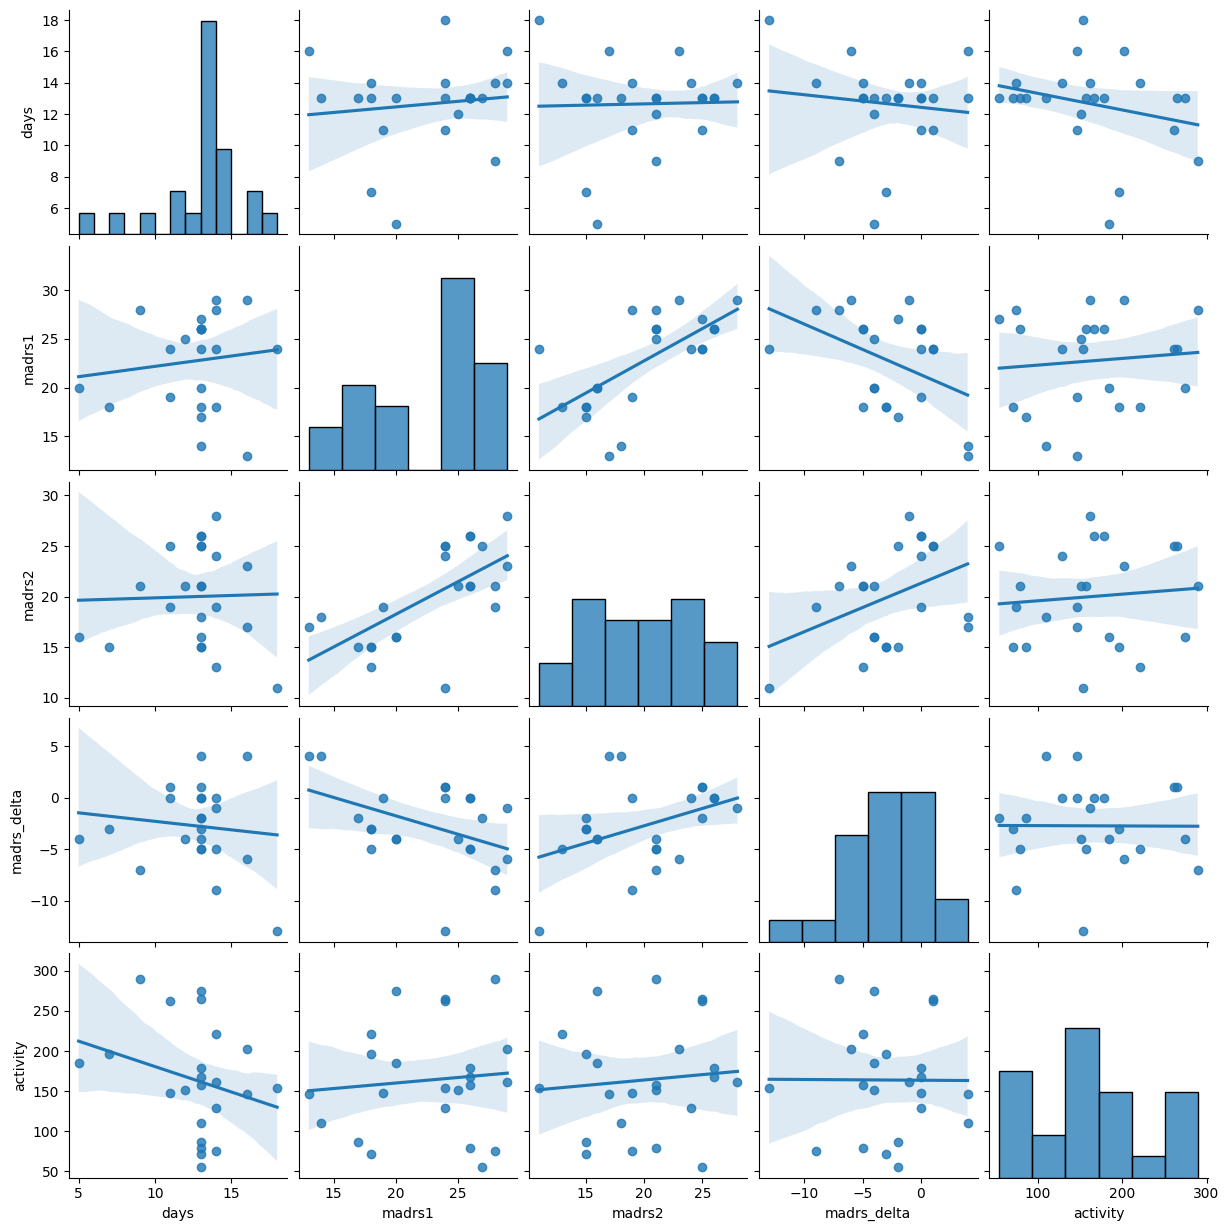

In [16]:
sns.pairplot(cond_df[features_num], kind='reg')

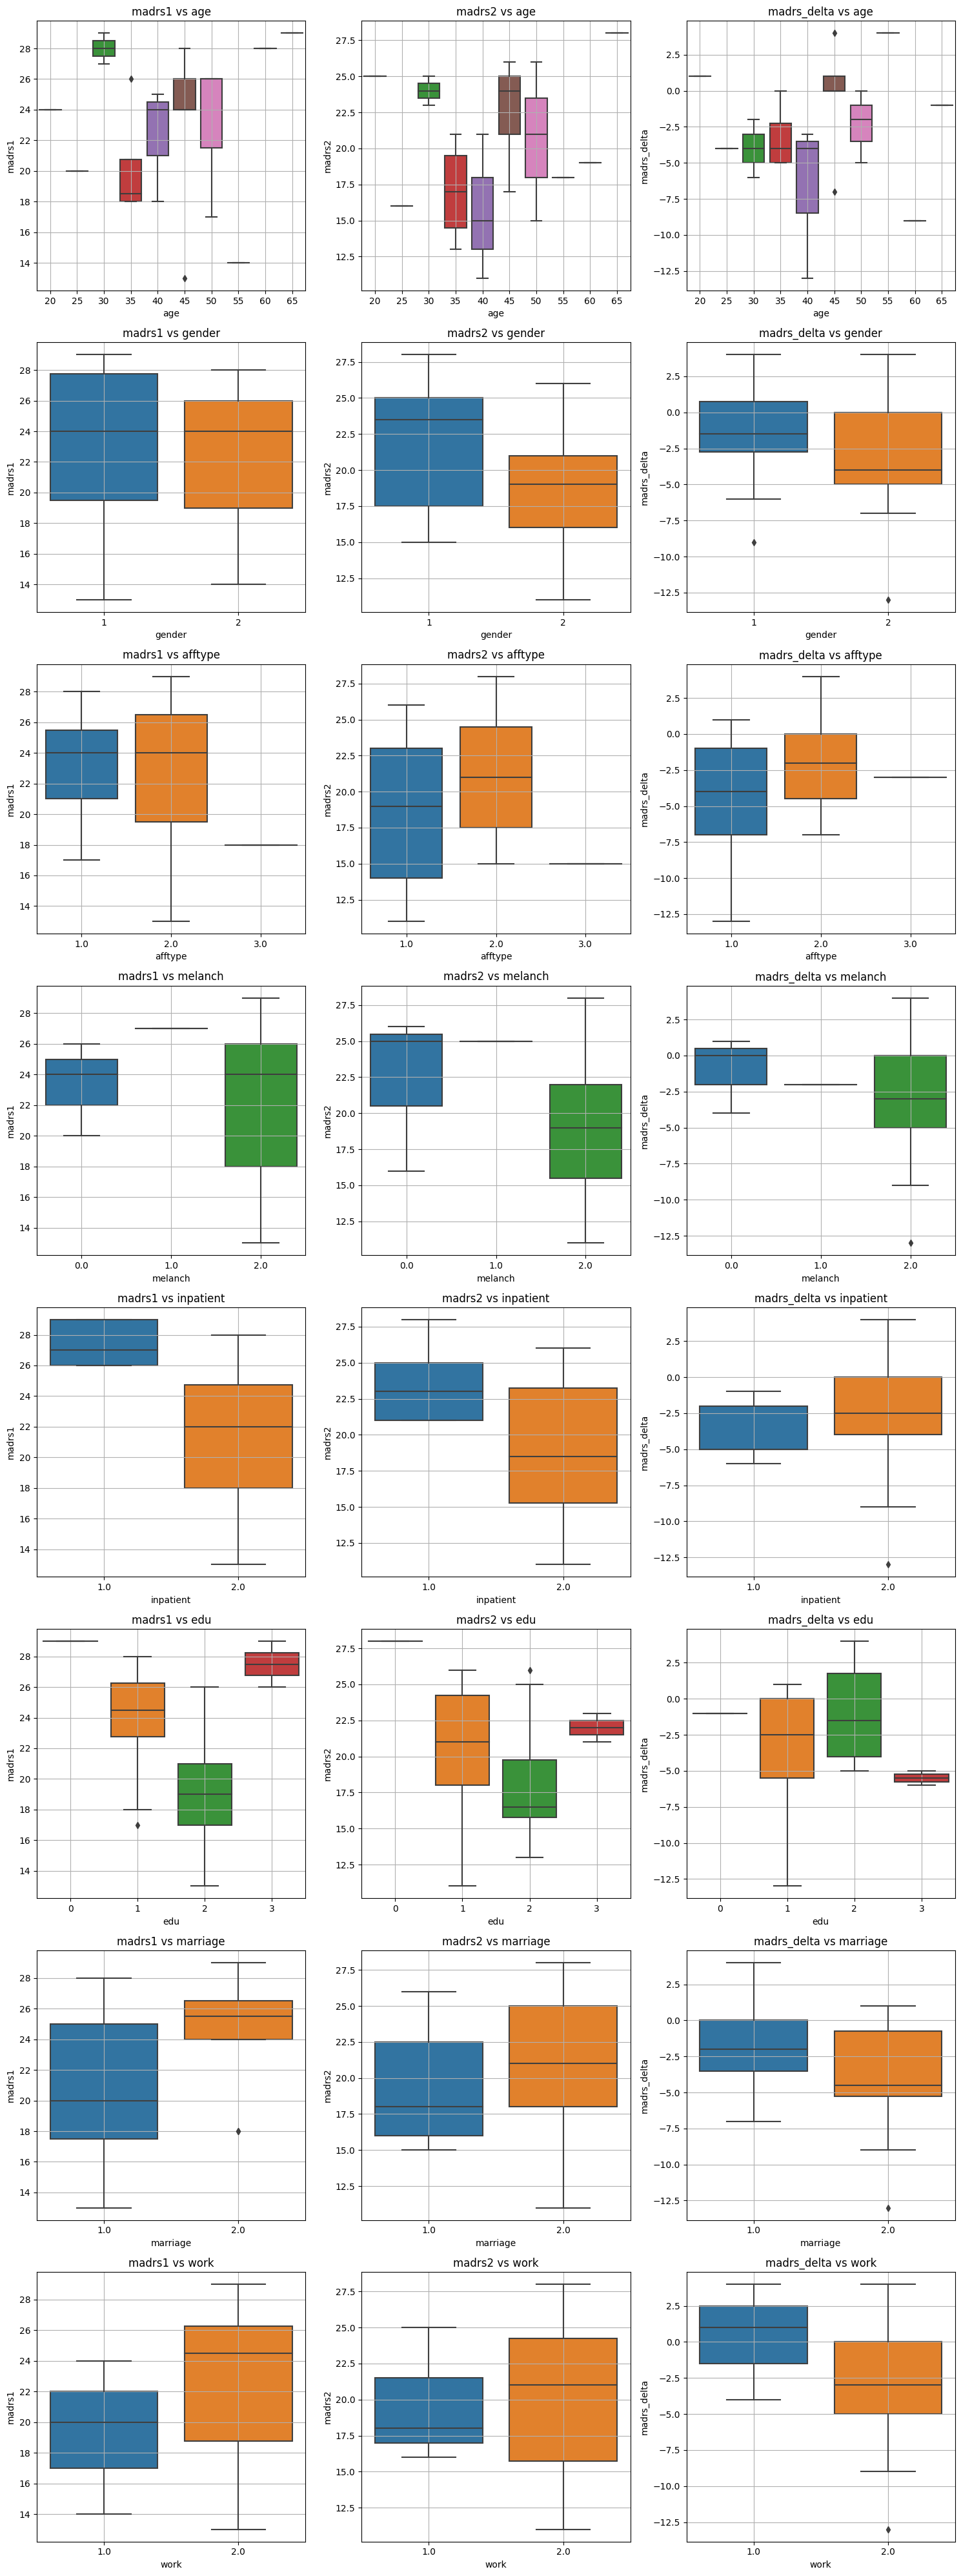

In [17]:
rows = len(features_cat)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5*rows))
for ax, f in zip(axes, features_cat):
    for i, madrs in enumerate(['madrs1', 'madrs2', 'madrs_delta']):
        sns.boxplot(data=cond_df, x=f, y=madrs, ax=ax[i])
        ax[i].set_title(f'{madrs} vs {f}')
        ax[i].grid()
fig.tight_layout()

Text(0.5, 1.0, 'Correlation heatmap')

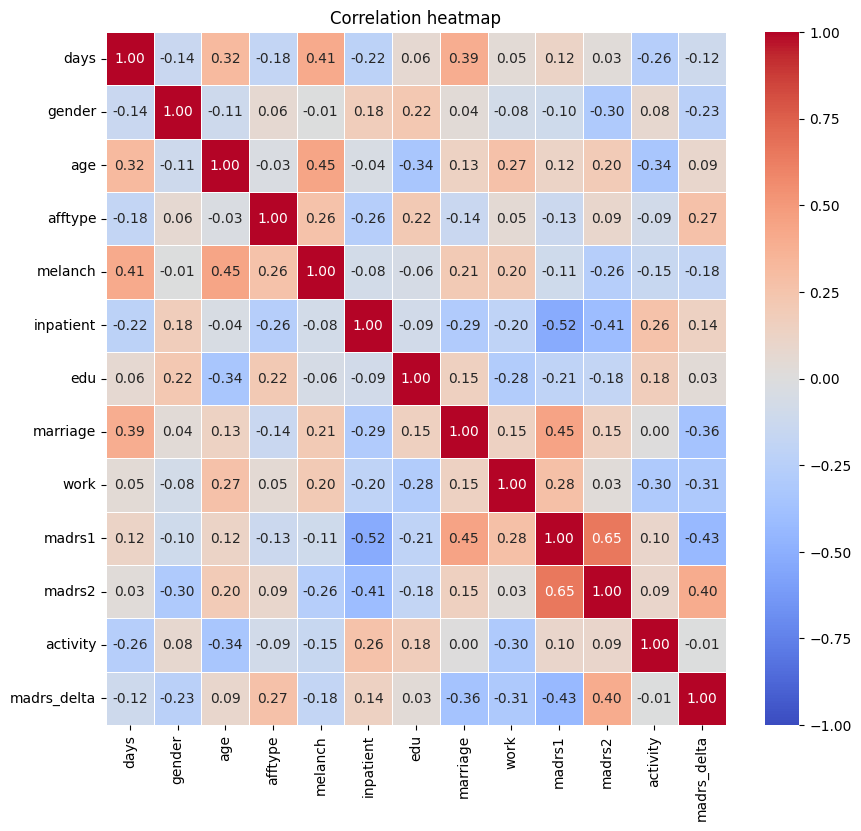

In [18]:
plt.figure(figsize=(10,9))
sns.heatmap(
    cond_df.drop(columns=['number', 'condition']).corr(),
    annot=True, fmt='.2f',
    linewidth=0.5,
    cmap='coolwarm',
    vmin=-1, vmax=1
)
plt.title(f'Correlation heatmap')

# Interactive parallel coordinates plot

In [19]:
!pip install hiplot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.2/863.2 kB 17.5 MB/s eta 0:00:00


In [20]:
import hiplot as hip

In [21]:
cols = [
    'condition', 'gender', 'days', 'age', 'activity',
    # The following columns are only included for the condition group
    # 'afftype', 'melanch', 'inpatient', 'edu', 'marriage', 'work', 'madrs1', 'madrs_delta'
]
exp = hip.Experiment.from_iterable(df[cols[::-1]].to_dict(orient='records'))
exp.colorby = 'condition'
exp.display()

<IPython.core.display.Javascript object>